In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from transformers import LogTransformer, SquareRootTransformer, ZScoreTrimmer, UpperBoundTrimmer, LowerBoundTrimmer, FillNaColumnTransformer, KNNColumnImputer, OneHotColumnEncoder, OrdinalColumnEncoder, ColumnDropper, StandardColumnScaler, ClusterSimilarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [2]:
df = pd.read_csv("data/belgian_property_prices.csv")

In [3]:
numerical_features = [
    "bathrooms",
    "bedrooms",
    "co2_emission",
    "cadastral_income",
    "construction_year",
    "living_area",
    "primary_energy_consumption",
    "street_frontage_width",
    "surface_of_the_plot",
    "toilets",
    "price"
    ]

In [4]:
categorical_features = [
    "building_condition",
    "number_of_frontages",
    "energy_class",
    ]

In [5]:
geospatial_features = ["lat","lng"]

In [6]:
df = df.dropna(subset=geospatial_features)

In [7]:
number_of_clusters = 8
cluster_simil = ClusterSimilarity(columns=["lat", "lng"], n_clusters=number_of_clusters, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(df, sample_weight=df.price)

for i in range(1,number_of_clusters+1):
    feature_name = f"Cluster_{i}_similarity"
    df[feature_name] = similarities[:,i-1]
    numerical_features.append(feature_name)

c:\Repositories\OpenUniversiteit\BelgianHousingPrices\house-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
features_to_drop = set(df.columns).difference(numerical_features).difference(categorical_features).difference(geospatial_features)

In [9]:
len(list(features_to_drop)+geospatial_features+categorical_features+numerical_features)

62

In [10]:
df["price_cat"] = pd.cut(df.price, bins=[0,250000,500000,750000,1000000,np.inf], labels=[0,1,2,3,4])
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df.price_cat, random_state=42)

for set_ in (train_set, test_set):
    set_.drop("price_cat", axis=1, inplace=True)

In [11]:
pipeline = Pipeline([
    ("column_dropping", ColumnDropper(columns=features_to_drop)),
    ("log_transforms", LogTransformer(columns=[
        "co2_emission",
        "cadastral_income",
        "living_area",
        "surface_of_the_plot",
        "price"
    ])),
    ("square_root_transforms", SquareRootTransformer(columns=[
        "bathrooms",
        "primary_energy_consumption",
    ])),
    ("zscore_trimming", ZScoreTrimmer(columns=[
        "primary_energy_consumption",
    ])),                                           
    ("upperbound_trimming", UpperBoundTrimmer(column_boundaries={
        "bathrooms": 3,
        "bedrooms":10,
        "co2_emission": 10,
        "toilets":10,
        "number_of_frontages":4
    })),
     ("lowerbound_trimming", LowerBoundTrimmer(column_boundaries={
        "co2_emission":0,
        "cadastral_income":4,
        "living_area":3,
        "surface_of_the_plot":0,
        "number_of_frontages":1,
        "price": 11
     })), 
    ('filling na', FillNaColumnTransformer(fill_value='Missing', columns=[
        "building_condition",
        "energy_class", 
    ])),
    ('filling na2', FillNaColumnTransformer(fill_value=0, columns=categorical_features)),     
     ("one_hot_encoding", OneHotColumnEncoder(columns=[
        "building_condition",
        "number_of_frontages",
    ])),
    ("ordinal_encoding", OrdinalColumnEncoder(columns=[
        "energy_class",
        ])),
    ("KNN_imputing", KNNColumnImputer(n_neighbors=5,columns=numerical_features))
])

In [12]:

prepared_train_set = data=pipeline.fit_transform(train_set)

ZScoreTrimmer - Trimmed a total of 1 columns and removed 1 outliers.
UpperBoundTrimmer - Column bathrooms: 9 outliers removed. Max value of 3.605551275463989 reduced to 3.0.
UpperBoundTrimmer - Column bedrooms: 13 outliers removed. Max value of 25.0 reduced to 10.0.
UpperBoundTrimmer - Column co2_emission: 1 outliers removed. Max value of 10.943004258145342 reduced to 9.828386780026877.
UpperBoundTrimmer - Column toilets: 0 outliers removed. Max value of 10.0 reduced to 10.0.
UpperBoundTrimmer - Column number_of_frontages: 0 outliers removed. Max value of 4.0 reduced to 4.0.
LowerBoundTrimmer - Column co2_emission: 16 outliers removed. Min value of 0.0 reduced to 0.6931471805599453.
LowerBoundTrimmer - Column cadastral_income: 11 outliers removed. Min value of 0.0 reduced to 4.499809670330265.
LowerBoundTrimmer - Column living_area: 0 outliers removed. Min value of 3.6888794541139363 reduced to 3.6888794541139363.
LowerBoundTrimmer - Column surface_of_the_plot: 3 outliers removed. Min 

In [13]:
y_columns = ["price"]
X_columns =list(prepared_train_set.columns)
X_columns.remove("price")

In [14]:
param_distributions = [{
'n_estimators': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
"max_depth": [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100],
"min_samples_split": [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50],
"min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50],
}]

rnd_search = HalvingRandomSearchCV(RandomForestRegressor(random_state=42), param_distributions, cv=3, scoring='neg_mean_squared_error', verbose=10)
rnd_search.fit(prepared_train_set[X_columns], np.ravel(prepared_train_set[y_columns]))


In [15]:
rnd_search.best_params_

NameError: name 'rnd_search' is not defined

In [ ]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [17]:
cv_res.head(10)

In [18]:

prepared_test_set = data=pipeline.fit_transform(test_set)

ZScoreTrimmer - Trimmed a total of 1 columns and removed 1 outliers.
UpperBoundTrimmer - Column bathrooms: 2 outliers removed. Max value of 3.605551275463989 reduced to 3.0.
UpperBoundTrimmer - Column bedrooms: 4 outliers removed. Max value of 14.0 reduced to 9.0.
UpperBoundTrimmer - Column co2_emission: 0 outliers removed. Max value of 9.21024036697585 reduced to 9.21024036697585.
UpperBoundTrimmer - Column toilets: 0 outliers removed. Max value of 9.0 reduced to 9.0.
UpperBoundTrimmer - Column number_of_frontages: 1 outliers removed. Max value of 10.0 reduced to 4.0.
LowerBoundTrimmer - Column co2_emission: 4 outliers removed. Min value of 0.0 reduced to 0.6931471805599453.
LowerBoundTrimmer - Column cadastral_income: 4 outliers removed. Min value of 0.0 reduced to 4.23410650459726.
LowerBoundTrimmer - Column living_area: 1 outliers removed. Min value of 2.70805020110221 reduced to 3.4657359027997265.
LowerBoundTrimmer - Column surface_of_the_plot: 0 outliers removed. Min value of 2.

In [19]:
random_forest = RandomForestRegressor(random_state=42, n_estimators=170, min_samples_split=2, min_samples_leaf=2, max_depth=70)

In [20]:
random_forest.fit(prepared_test_set[X_columns], np.ravel(prepared_test_set[y_columns]))

RandomForestRegressor(max_depth=70, min_samples_leaf=2, n_estimators=170,
                      random_state=42)

Text(0.5, 1.0, 'Global Feature Importance')

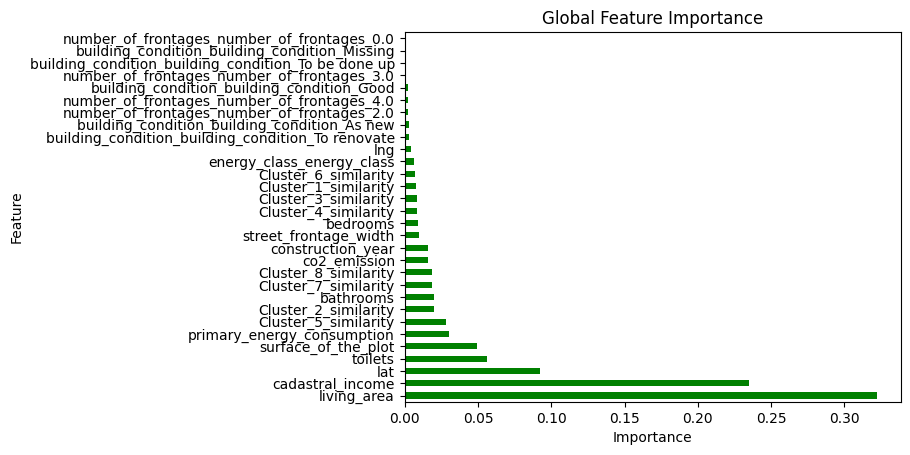

In [21]:
global_importances = pd.Series(random_forest.feature_importances_, index=X_columns)
global_importances.sort_values(ascending=False, inplace=True)
global_importances = global_importances.head(30)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance")

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_columns = ["price"]
X_columns =list(prepared_test_set.columns)
X_columns.remove("price")
final_predictions = np.exp(random_forest.predict(prepared_test_set[X_columns]))
test = np.exp(prepared_test_set[y_columns])

final_rmse = mean_absolute_error(test, final_predictions)
print(final_rmse) 

53828.22176296563


In [23]:
test["predictions"] = final_predictions

In [24]:
test["error"] = np.abs(test["predictions"] - test["price"])

C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_48532\2906979383.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_rmse_by_price = test.groupby('price_interval')['error'].mean().reset_index()
C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_48532\2906979383.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='price_interval', y='error', data=mean_rmse_by_price, ci=None)  #


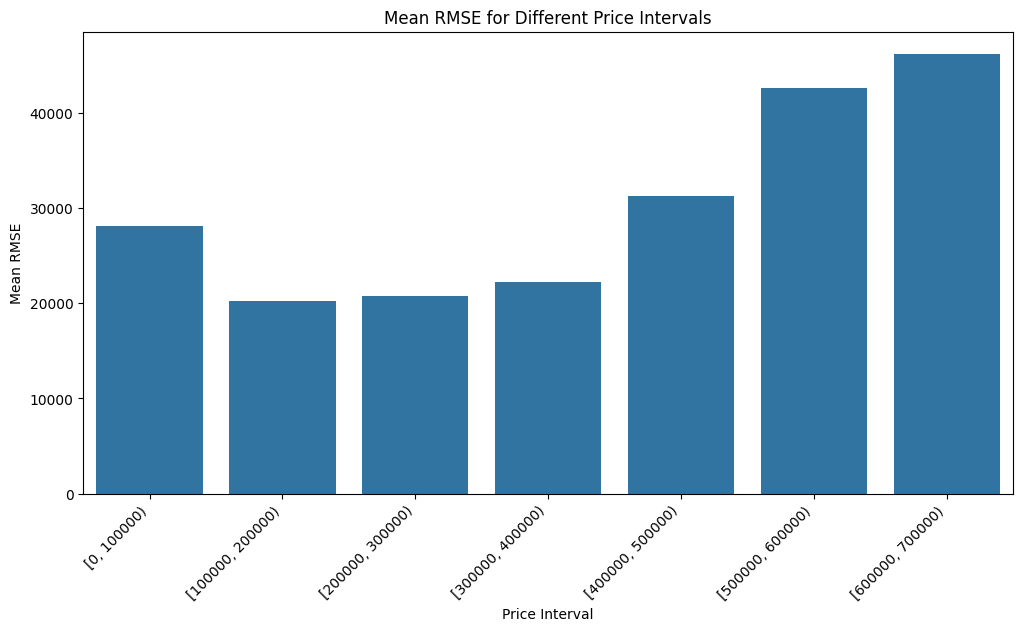

In [30]:
import seaborn as sns
test['price_interval'] = pd.cut(test['price'], bins=np.arange(0, 700001, 100000), right=False)

mean_rmse_by_price = test.groupby('price_interval')['error'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='price_interval', y='error', data=mean_rmse_by_price, ci=None)  #
plt.xlabel('Price Interval')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE for Different Price Intervals')
plt.xticks(rotation=45, ha='right') 
plt.show()

C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_48532\1612812851.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_rmse_by_price = test.groupby('price_interval')['error_relative'].mean().reset_index()
C:\Users\joachim.verschelde\AppData\Local\Temp\ipykernel_48532\1612812851.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='price_interval', y='error_relative', data=mean_rmse_by_price, ci=None)  #


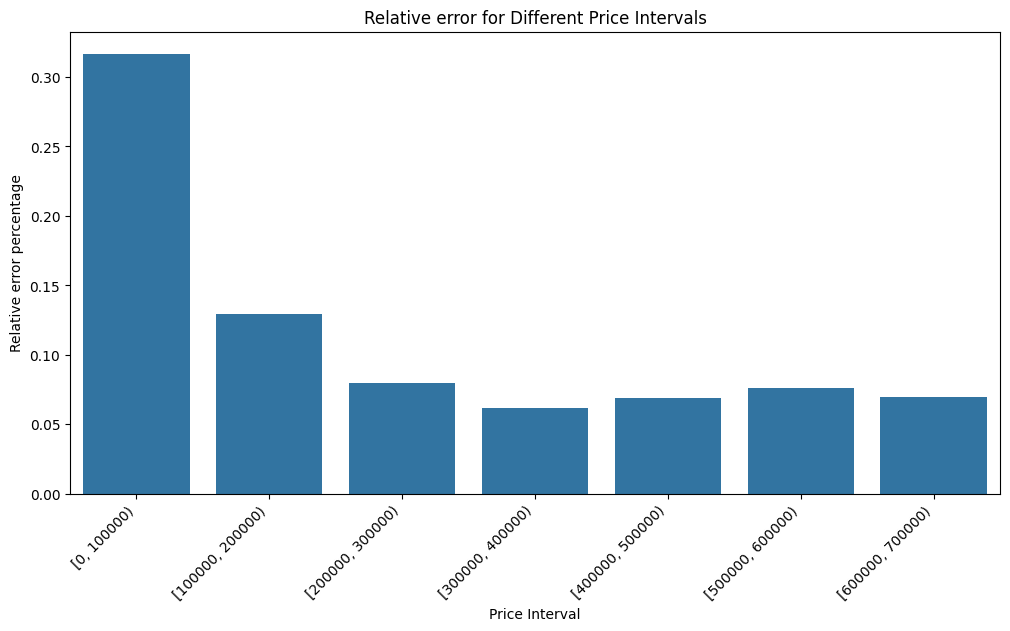

In [29]:
test['error_relative'] = test.error / test.price
test['price_interval'] = pd.cut(test['price'], bins=np.arange(0, 700001, 100000), right=False)

mean_rmse_by_price = test.groupby('price_interval')['error_relative'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='price_interval', y='error_relative', data=mean_rmse_by_price, ci=None)  #
plt.xlabel('Price Interval')
plt.ylabel('Relative error percentage')
plt.title('Relative error for Different Price Intervals')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [27]:
test["error_relative"].mean()

0.09125160487872995

In [28]:
test["error_relative"].median()

0.06726132554853989